# Data Wrangling: WeRateDogs tweeter data

## Table of Contents
- [Introduction](#intro)
- [1. Wrangling Data](#wrangling)
    - [1.1 Gathering](#gathering)
        - [1.1.1 Archive dataset](#archive)
        - [1.1.2 Image prediction dataset](#image_pred)
        - [1.1.3 Additional API data](#api)
    - [1.2 Assessment](#assess)
    - [1.3 Cleaning](#cleaning)
- [2. Storing clean data](#storing_clean)
- [3 Analysis & Visualisation](#analysis_and_vis)
- [4. Conclusion](#conclusion)

<a id='intro'></a>
### Introduction

In this project, we will focus on data wrangling part of the data analysis process. It will consist of 3 main parts: gathering, assessment, and cleaning. We will identify at least 8 quality issues and at least 2 tidiness issues in the datasets. After a complete clean-up, we will present an analysis of at least 3 insights and 1 visualisation. 
The data we will be working with represents an archive of tweeter ratings of dogs from the WeRateDogs page. Moreover, we are given an additional dataset with image predictions of a breed of each dog. In addition, we will also collect some supplementive data via tweeter api.

<a id='wrangling'></a>
### Wrangling Data

In [1010]:
# importing all necessary libraries for the entire project

import numpy as np
import pandas as pd
import requests as rq
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
from pandas import json_normalize
from PIL import Image
import matplotlib.dates as dt
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO

<a id='gathering'></a>
## Step 1. Gathering

For this project, we will have 3 sources to gather the data from.

<a id='archive'></a>
#### Archive Dataset

We are given a csv file in the same workspace as this notebook. We can directly capture it in a dataframe format.

In [1011]:
# 1) gathering data from twitter-archive-enhanced.csv

df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


<a id='image_pred'></a>
#### Image Prediction Dataset

This dataset is storred on a cloud, thus we need to use the requests library to request the data.

In [1012]:
# 2) gathering data from image_predictions.tsv using requests library

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r_images = rq.get(url, allow_redirects=True)

# should return 200 if the request was successful
r_images.status_code

200

In [1013]:
# saving the data into a tsv file
open('images.tsv', 'wb').write(r_images.content)

335079

In [1014]:
# reading the images data into a dataframe
df_images = pd.read_csv('images.tsv', sep='\t', header=0)

In [1015]:
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='api'></a>
#### Additional API data

To present a wholesome analysis, we need to gather some additional data via tweepy api. I was not able to create a tweeter developer's account due to travelling arrangements and consequitive restrictions. However, I am provided with a text file that contains json information that we can read into a dataframe for further manipulations.

In [1016]:
# 3) gathering additional twitter data

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json_udacity.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

Fail
288: 838561493054533637
Fail
289: 838476387338051585
Fail
290: 838201503651401729
Fail
291: 838150277551247360
Fail
292: 838085839343206401
Fail
293: 838083903487373313
Fail
294: 837820167694528512
Fail
295: 837482249356513284
Fail
296: 837471256429613056
Fail
297: 837366284874571778
Fail
298: 837110210464448512
Fail
299: 837012587749474308
Fail
300: 836989968035819520
Fail
301: 836753516572119041
Fail
302: 836677758902222849
Fail
303: 836648853927522308
Fail
304: 836397794269200385
Fail
305: 836380477523124226
Fail
306: 836260088725786625
Fail
307: 836001077879255040
Fail
308: 835685285446955009
Fail
309: 835574547218894849
Fail
310: 835536468978302976
Fail
311: 835309094223372289
Fail
312: 835297930240217089
Fail
313: 835264098648616962
Fail
314: 835246439529840640
Fail
315: 835172783151792128
Fail
316: 835152434251116546
Fail
317: 834931633769889797
Fail
318: 834786237630337024
Fail
319: 834574053763584002
Fail
320: 834477809192075265
Fail
321: 834458053273591808
Fail
322: 8342

Fail
571: 801854953262350336
Fail
572: 801538201127157760
Fail
573: 801285448605831168
Fail
574: 801167903437357056
Fail
575: 801127390143516673
Fail
576: 801115127852503040
Fail
577: 800859414831898624
Fail
578: 800855607700029440
Fail
579: 800751577355128832
Fail
580: 800513324630806528
Fail
581: 800459316964663297
Fail
582: 800443802682937345
Fail
583: 800388270626521089
Fail
584: 800188575492947969
Fail
585: 800141422401830912
Fail
586: 800018252395122689
Fail
587: 799774291445383169
Fail
588: 799757965289017345
Fail
589: 799422933579902976
Fail
590: 799308762079035393
Fail
591: 799297110730567681
Fail
592: 799063482566066176
Fail
593: 798933969379225600
Fail
594: 798925684722855936
Fail
595: 798705661114773508
Fail
596: 798701998996647937
Fail
597: 798697898615730177
Fail
598: 798694562394996736
Fail
599: 798686750113755136
Fail
600: 798682547630837760
Fail
601: 798673117451325440
Fail
602: 798665375516884993
Fail
603: 798644042770751489
Fail
604: 798628517273620480
Fail
605: 7985

Fail
854: 765371061932261376
Fail
855: 765222098633691136
Fail
856: 764857477905154048
Fail
857: 764259802650378240
Fail
858: 763956972077010945
Fail
859: 763837565564780549
Fail
860: 763183847194451968
Fail
861: 763167063695355904
Fail
862: 763103485927849985
Fail
863: 762699858130116608
Fail
864: 762471784394268675
Fail
865: 762464539388485633
Fail
866: 762316489655476224
Fail
867: 762035686371364864
Fail
868: 761976711479193600
Fail
869: 761750502866649088
Fail
870: 761745352076779520
Fail
871: 761672994376806400
Fail
872: 761599872357261312
Fail
873: 761371037149827077
Fail
874: 761334018830917632
Fail
875: 761292947749015552
Fail
876: 761227390836215808
Fail
877: 761004547850530816
Fail
878: 760893934457552897
Fail
879: 760656994973933572
Fail
880: 760641137271070720
Fail
881: 760539183865880579
Fail
882: 760521673607086080
Fail
883: 760290219849637889
Fail
884: 760252756032651264
Fail
885: 760190180481531904
Fail
886: 760153949710192640
Fail
887: 759943073749200896
Fail
888: 7599

Fail
1132: 728986383096946689
Fail
1133: 728760639972315136
Fail
1134: 728751179681943552
Fail
1135: 728653952833728512
Fail
1136: 728409960103686147
Fail
1137: 728387165835677696
Fail
1138: 728046963732717569
Fail
1139: 728035342121635841
Fail
1140: 728015554473250816
Fail
1141: 727685679342333952
Fail
1142: 727644517743104000
Fail
1143: 727524757080539137
Fail
1144: 727314416056803329
Fail
1145: 727286334147182592
Fail
1146: 727175381690781696
Fail
1147: 727155742655025152
Fail
1148: 726935089318363137
Fail
1149: 726887082820554753
Fail
1150: 726828223124897792
Fail
1151: 726224900189511680
Fail
1152: 725842289046749185
Fail
1153: 725786712245440512
Fail
1154: 725729321944506368
Fail
1155: 725458796924002305
Fail
1156: 724983749226668032
Fail
1157: 724771698126512129
Fail
1158: 724405726123311104
Fail
1159: 724049859469295616
Fail
1160: 724046343203856385
Fail
1161: 724004602748780546
Fail
1162: 723912936180330496
Fail
1163: 723688335806480385
Fail
1164: 723673163800948736
Fail
1165:

Fail
1406: 699323444782047232
Fail
1407: 699088579889332224
Fail
1408: 699079609774645248
Fail
1409: 699072405256409088
Fail
1410: 699060279947165696
Fail
1411: 699036661657767936
Fail
1412: 698989035503689728
Fail
1413: 698953797952008193
Fail
1414: 698907974262222848
Fail
1415: 698710712454139905
Fail
1416: 698703483621523456
Fail
1417: 698635131305795584
Fail
1418: 698549713696649216
Fail
1419: 698355670425473025
Fail
1420: 698342080612007937
Fail
1421: 698262614669991936
Fail
1422: 698195409219559425
Fail
1423: 698178924120031232
Fail
1424: 697995514407682048
Fail
1425: 697990423684476929
Fail
1426: 697943111201378304
Fail
1427: 697881462549430272
Fail
1428: 697630435728322560
Fail
1429: 697616773278015490
Fail
1430: 697596423848730625
Fail
1431: 697575480820686848
Fail
1432: 697516214579523584
Fail
1433: 697482927769255936
Fail
1434: 697463031882764288
Fail
1435: 697270446429966336
Fail
1436: 697259378236399616
Fail
1437: 697255105972801536
Fail
1438: 697242256848379904
Fail
1439:

Fail
1680: 682032003584274432
Fail
1681: 682003177596559360
Fail
1682: 681981167097122816
Fail
1683: 681891461017812993
Fail
1684: 681694085539872773
Fail
1685: 681679526984871937
Fail
1686: 681654059175129088
Fail
1687: 681610798867845120
Fail
1688: 681579835668455424
Fail
1689: 681523177663676416
Fail
1690: 681340665377193984
Fail
1691: 681339448655802368
Fail
1692: 681320187870711809
Fail
1693: 681302363064414209
Fail
1694: 681297372102656000
Fail
1695: 681281657291280384
Fail
1696: 681261549936340994
Fail
1697: 681242418453299201
Fail
1698: 681231109724700672
Fail
1699: 681193455364796417
Fail
1700: 680970795137544192
Fail
1701: 680959110691590145
Fail
1702: 680940246314430465
Fail
1703: 680934982542561280
Fail
1704: 680913438424612864
Fail
1705: 680889648562991104
Fail
1706: 680836378243002368
Fail
1707: 680805554198020098
Fail
1708: 680801747103793152
Fail
1709: 680798457301471234
Fail
1710: 680609293079592961
Fail
1711: 680583894916304897
Fail
1712: 680497766108381184
Fail
1713:

Fail
1954: 673662677122719744
Fail
1955: 673656262056419329
Fail
1956: 673636718965334016
Fail
1957: 673612854080196609
Fail
1958: 673583129559498752
Fail
1959: 673580926094458881
Fail
1960: 673576835670777856
Fail
1961: 673363615379013632
Fail
1962: 673359818736984064
Fail
1963: 673355879178194945
Fail
1964: 673352124999274496
Fail
1965: 673350198937153538
Fail
1966: 673345638550134785
Fail
1967: 673343217010679808
Fail
1968: 673342308415348736
Fail
1969: 673320132811366400
Fail
1970: 673317986296586240
Fail
1971: 673295268553605120
Fail
1972: 673270968295534593
Fail
1973: 673240798075449344
Fail
1974: 673213039743795200
Fail
1975: 673148804208660480
Fail
1976: 672997845381865473
Fail
1977: 672995267319328768
Fail
1978: 672988786805112832
Fail
1979: 672984142909456390
Fail
1980: 672980819271634944
Fail
1981: 672975131468300288
Fail
1982: 672970152493887488
Fail
1983: 672968025906282496
Fail
1984: 672964561327235073
Fail
1985: 672902681409806336
Fail
1986: 672898206762672129
Fail
1987:

Fail
2228: 668268907921326080
Fail
2229: 668256321989451776
Fail
2230: 668248472370458624
Fail
2231: 668237644992782336
Fail
2232: 668226093875376128
Fail
2233: 668221241640230912
Fail
2234: 668204964695683073
Fail
2235: 668190681446379520
Fail
2236: 668171859951755264
Fail
2237: 668154635664932864
Fail
2238: 668142349051129856
Fail
2239: 668113020489474048
Fail
2240: 667937095915278337
Fail
2241: 667924896115245057
Fail
2242: 667915453470232577
Fail
2243: 667911425562669056
Fail
2244: 667902449697558528
Fail
2245: 667886921285246976
Fail
2246: 667885044254572545
Fail
2247: 667878741721415682
Fail
2248: 667873844930215936
Fail
2249: 667866724293877760
Fail
2250: 667861340749471744
Fail
2251: 667832474953625600
Fail
2252: 667806454573760512
Fail
2253: 667801013445750784
Fail
2254: 667793409583771648
Fail
2255: 667782464991965184
Fail
2256: 667773195014021121
Fail
2257: 667766675769573376
Fail
2258: 667728196545200128
Fail
2259: 667724302356258817
Fail
2260: 667550904950915073
Fail
2261:

In [1017]:
# 3) transfering txt file into dataframe
filename = 'tweet_json.txt'

dict_additional_info = []

with open(filename) as file:
    for line in file:
        # each line contains a long json text for each particular tweet 
        # we should retrieve 'id', 'retweet_count', 'favorite_count' and store it in a dictionary
        # after parsing the whole file, we will transfer these values into a dataframe
        line_json = json.loads(line)
        dict_additional_info.append({'id': line_json['id'],
                                   'retweet_count': line_json['retweet_count'],
                                   'favorite_count': line_json['favorite_count']})

        
df_additional_info = pd.DataFrame(dict_additional_info, columns=['id',
                                                                'retweet_count',
                                                                'favorite_count'])
 
df_additional_info.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


<a id='assess'></a>
## Step 2. Assessment

We will perform both visual and programmatic assessment of each of the 3 dataframes gathered above. We will detect at least 8 quality and 2 tidiness issues in this part of the analysis. In the end, we will document our observations and findings.

#### Visual Assessment

In [1018]:
# 1.1) visual assessment of df_archive 
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


#### Observations for df_archive
Quality:
- missing data: all visible columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) with NaN values
- incorrect names in the 'name' column: 'None', 'a'

Tidiness:
- doggo, floofer, pupper, puppo columns should form a single column (they all represent stages of a dog)

In [1019]:
# 1.2) visual assessment of df_images
df_images

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


#### Observations for df_images
Quality:
- nondescriptive column headers: p1, p2, p1_conf, etc. 
- inconsistent represenation of dogs' breeds: starting from capital/lower case letters, using underscore
- records of non-dogs: orange, bagel, paper_towel, etc.
- columns from p1 to p3_dog should form a single column, we may not want to keep all possible breeds and probability for each of them

In [1020]:
# 1.3) visual assessment of df_additional_info
df_additional_info

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


#### Observations for df_additional_info 
Quality:
- erronous data type: favourite_count, retweet_count in a float format, thus meaningless .0 in the end
- id is stored in a different format compared to other dataframes: e+17

Tidiness:
- the table is separated from other tables, a tweet should form a single row in a single table

#### Programmatic assessment

In [1021]:
# 2.1) programmatic assessment of df_archive
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

There are 2356 non-null rows with sufficient information. However,

Quality:
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp are mostly null
- 59 records do not have expanded_urls
- erronous data type for timestamp: object instead of datetime

In [1022]:
# 2.2) programmatic assessment of df_images
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Same findings as per visual assessment

In [1023]:
# 2.3) programmatic assessment of df_additional_info
df_additional_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


Quality:
- id is in float64 format, while our previous dataframes store the id in int64 format, but in the end we should store ids in a string format since no numeric operations can be performed on it
- name of id columns is different from other tables' tweet_id

We have assessed all 3 dataframes both visually and programmatically.
Let's document the final observations and findings.

### Observations and Findings

### Quality issues:
#### df_archive:
- 1) missing data: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp with NaN values. 
- 2) incorrect names in the 'name' column: 'None', 'a'
- 3) 59 records do not have expanded_urls
- 4) erronous data type for timestamp: object instead of datetime

#### df_images:
- 5) inconsistent represenation of dogs' breed: starting from capital/lower case letters, using underscore char
- 6) records of non-dogs: orange, bagel, paper_towel, etc.
- 7) p1, p2, p3 are non-descriptive and this may not be preffered to keep records of all the possible breeds and confidence of classification for each observation

#### df_additional_info
- 8) id, favourite_count, retweet_count in a float format: meaningless .0 in the end
- 9) column name 'id' does not match column name 'tweet_id' in other tables


### Tidiness issues:
#### df_archive:
- 1) doggo, floofer, pupper, puppo should form one single column

#### df_images:
- 2) the table is separated from archive table

#### df_additional_info:
- 3) the table is separated from other tables

## Step 3. Cleaning

In [1024]:
# before starting cleaning, we need to copy all the data and perform the cleaning on the copies to avoid accidently loosing some data

df_archive_copy = df_archive.copy()
df_images_copy = df_images.copy()
df_additional_info_copy = df_additional_info.copy()

## Cleaning quality issues 
### df_archive_copy
### Define 
Quality 1) Remove rows with incorrect names such as 'a', 'None'

In [1025]:
df_archive_copy[df_archive_copy['name'] == 'None'].shape[0]

745

In [1026]:
df_archive_copy[df_archive_copy['name'] == 'a'].shape[0]

55

> There are 800 records with incorrect names of the dogs, we should remove them

In [1027]:
df_archive_copy.drop(df_archive_copy[df_archive_copy.name == 'a'].index, inplace=True)
df_archive_copy

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,666063827256086533,NaN,NaN,2015-11-16 01:22:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the happiest dog you will ever see. Ve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666063827...,10,10,the,None,None,None,None
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8,10,the,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


> After removing the records with 'a' names, we can still see that some records have other ambiguous names such as 'an', 'the'. 
> We should remove those records too.

### Define
Quality 1.1) Remove all records that have a name starting with a lower case letter
### Code

In [1028]:
df_archive_copy = df_archive_copy[df_archive_copy['name'].str[0].str.isupper()]

### Test

In [1029]:
df_archive_copy[df_archive_copy['name'].str[0].str.islower()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


> The returned dataframe is empty, thus no more records with a name starting with a lowercase 

In [1030]:
df_archive_copy.shape[0]

2247

> Though we have defined that we want to remove the data with 'None' names, we now have 2247 records left in our df_archive_copy dataframe, and there are 745 records with 'None' name. 
> It is a rather significant fraction of the total records left. Therefor, we will not remove those records.

## Define
Quality 2) Drop in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp columns, since they are mostly null
## Code

In [1031]:
df_archive_copy = df_archive_copy.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

## Test

In [1032]:
df_archive_copy.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


### Define
Quality 3) Remove 59 records that do not have expanded_urls (null)
### Code

In [1033]:
df_archive_copy.dropna(subset = ['expanded_urls'], inplace=True)

## Test

In [1034]:
sum(df_archive_copy.expanded_urls.isnull() == True)

0

### Define 
Quality 4) Change datatype of timestamp from object to datetime 
### Code

In [1035]:
df_archive_copy['timestamp'] = pd.to_datetime(df_archive_copy['timestamp'])

### Test

In [1036]:
df_archive_copy.timestamp.dtype

datetime64[ns, UTC]

### df_images_copy
### Define 
Quality 5) Change all data under p1, p2, p3 to lowercase letter to make the dataframe consistent (dogs' breed)
### Code

In [1037]:
df_images_copy['p1'] = df_images_copy['p1'].str.lower()
df_images_copy['p2'] = df_images_copy['p2'].str.lower()
df_images_copy['p3'] = df_images_copy['p3'].str.lower()

### Test

In [1038]:
sum(df_images_copy.p1.str.islower() == False)

0

In [1039]:
df_images_copy

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True


### Define
Quality 6) Remove records if p1_dog, p2_dog, p3_dog are all False. These records were identified as non-dogs, thus we don't need them.
### Code

In [1040]:
nondog_indexes = df_images_copy[((df_images_copy.p1_dog == False) & (df_images_copy.p2_dog == False) & (df_images_copy.p3_dog == False))].index
nondog_indexes

Int64Index([   6,   17,   18,   21,   25,   29,   45,   50,   51,   53,
            ...
            1953, 1956, 1975, 1979, 2012, 2021, 2022, 2046, 2052, 2074],
           dtype='int64', length=324)

In [1041]:
# dropping the rows based on the indexes, and resetting indexes after
df_images_copy.drop(nondog_indexes, inplace=True)
df_images_copy.reset_index(inplace=True)

### Test

In [1042]:
df_images_copy[((df_images_copy.p1_dog == False) & (df_images_copy.p2_dog == False) & (df_images_copy.p3_dog == False))]

,index,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [1043]:
df_images_copy['p1'].head(10)

0    welsh_springer_spaniel
1                   redbone
2           german_shepherd
3       rhodesian_ridgeback
4        miniature_pinscher
5      bernese_mountain_dog
6                      chow
7             shopping_cart
8          miniature_poodle
9          golden_retriever
Name: p1, dtype: object

### Define
Quality 7) Create new columns 'breed', 'confidence'. Populate them based on the column p1 to p3_dog accordingly. Then drop reduntant columns from p1 to p3_dog.
### Code

In [1044]:
breeds = []
predictions = []

for i in range(len(df_images_copy)):
    if df_images_copy['p1_dog'][i] == True:
        breeds.append(df_images_copy['p1'][i])
        predictions.append(df_images_copy['p1_conf'][i])
    elif df_images_copy['p2_dog'][i] == True:
        breeds.append(df_images_copy['p2'][i])
        predictions.append(df_images_copy['p2_conf'][i])
    else:
        breeds.append(df_images_copy['p3'][i])
        predictions.append(df_images_copy['p3_conf'][i])

In [1045]:
df_images_copy['breed'] = breeds
df_images_copy['prediction'] = predictions

In [1046]:
df_images_copy.head()

,index,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,prediction
0,0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,welsh_springer_spaniel,0.465074
1,1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,german_shepherd,0.596461
3,3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,rhodesian_ridgeback,0.408143
4,4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,miniature_pinscher,0.560311


In [1047]:
# now we can drop the redundant columns
df_images_copy.drop(df_images_copy.loc[:, 'p1':'p3_dog'].columns, axis=1, inplace=True)

### Test

In [1048]:
df_images_copy.head()

,index,tweet_id,jpg_url,img_num,breed,prediction
0,0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074
1,1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461
3,3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143
4,4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


### df_additional_info_copy
### Define:
Quality 8) Change dtype of id, favourite_count, retweet_count from float to int and remove meaningless .0 in the end (will be done automatically after the change of the datatype).
### Code

In [1049]:
df_additional_info_copy.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [1050]:
df_additional_info_copy.id = df_additional_info_copy.id.astype(int)
df_additional_info_copy.favorite_count = df_additional_info_copy.favorite_count.astype(int)
df_additional_info_copy.retweet_count = df_additional_info_copy.retweet_count.astype(int)

### Test

In [1051]:
df_additional_info_copy.dtypes

id                int64
retweet_count     int64
favorite_count    int64
dtype: object

In [1052]:
df_additional_info_copy.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


### Define:
Quality 9) Change column name 'id' to 'tweet_id' to match the names in 2 other tables for future join 
### Code

In [1053]:
# changing column name from 'id' to 'tweet_id' in additional info df to prepare for merge
df_additional_info_copy.rename(columns={'id': 'tweet_id'}, inplace=True)

### Test

In [1054]:
df_additional_info_copy.columns
df_additional_info_copy.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Cleaning tidiness issues:
### df_archives_copy
### Define
Tidiness 1) Create a new column 'stage' and popuate it with the appropriate variable: doggo, floofer, pupper, puppo. Then drop the out-dated columns 'doggo', 'floofer', 'pupper', 'puppo'
### Code

In [1055]:
df_archive_copy.doggo.replace('None', '', inplace=True)
df_archive_copy.floofer.replace('None', '', inplace=True)
df_archive_copy.pupper.replace('None', '', inplace=True)
df_archive_copy.puppo.replace('None', '', inplace=True)

In [1056]:
df_archive_copy['stage'] = df_archive_copy['doggo'] + df_archive_copy['floofer'] + df_archive_copy['pupper'] + df_archive_copy['puppo']

### Test

In [1057]:
df_archive_copy['stage'].unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

> We can see that the new column 'stage' was populated twice in some cases when 2 stages were presented. We need to reiterate to fix quality issue.
### Define
Tidiness 1.1) Repopulate the fields in 'stage' column with a comma separated value for the mixed data: doggopuppo, doggofloofer, doggopupper 
### Code

In [1058]:
df_archive_copy.loc[df_archive_copy.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'
df_archive_copy.loc[df_archive_copy.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
df_archive_copy.loc[df_archive_copy.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'

### Test

In [1059]:
df_archive_copy['stage'].unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

> Now we can drop the outdated 4 columns to make the df tidy

In [1060]:
df_archive_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)
df_archive_copy.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


### df_images_copy
### Define
Tidiness 2) Merge the table with the archive copy on tweet_id key. Then change the dtype of tweet_id to string, since we can't do any numeric operations with ids.
### Code

In [1061]:
df_archive_copy.tweet_id.shape[0]

2188

In [1062]:
df_images_copy.tweet_id.shape[0]

1751

In [1063]:
df_archive_copy = pd.merge(left=df_archive_copy, right=df_images_copy, how='left', on='tweet_id')
df_archive_copy.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,index,jpg_url,img_num,breed,prediction
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,2073.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,2072.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012


In [1064]:
df_archive_copy.drop(["index"], axis=1, inplace=True)

### Test

In [1065]:
df_archive_copy.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,breed,prediction
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012


### df_additional_info_copy
### Define
Tidiness 3) Merge df_additional_info_copy with df_archive_copy on tweet_id
### Code

In [1066]:
df_archive_copy.tweet_id.shape[0]

2188

In [1067]:
df_additional_info_copy.shape[0]

2354

In [1068]:
df_archive_copy = pd.merge(left=df_archive_copy, right=df_additional_info_copy, how='left', on='tweet_id')
df_archive_copy

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,breed,prediction,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,NaN,NaN,NaN,NaN,8853.0,39467.0
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,chihuahua,0.323581,6514.0,33819.0
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012,4328.0,25461.0
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,labrador_retriever,0.168086,8964.0,42908.0
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,9774.0,41048.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,666082916733198337,2015-11-16 02:38:37+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,https://twitter.com/dog_rates/status/666082916...,6,10,None,,https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg,1.0,pug,0.489814,47.0,121.0
2184,666073100786774016,2015-11-16 01:59:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Let's hope this flight isn't Malaysian (lol). ...,https://twitter.com/dog_rates/status/666073100...,10,10,None,,https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg,1.0,walker_hound,0.260857,174.0,335.0
2185,666071193221509120,2015-11-16 01:52:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a northern speckled Rhododendron....,https://twitter.com/dog_rates/status/666071193...,9,10,None,,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg,1.0,gordon_setter,0.503672,67.0,154.0
2186,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,miniature_pinscher,0.560311,41.0,111.0


### Test

In [1069]:
df_archive_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'stage', 'jpg_url',
       'img_num', 'breed', 'prediction', 'retweet_count', 'favorite_count'],
      dtype='object')

In [1070]:
df_archive_copy.shape[0]

2188

<a id='storing_clean'></a>
## Step 4. Storing Clean Data

In [1071]:
# after successfully cleaning 8 quality and 3 tidiness issues, we can store the final tables in a csv format
df_archive_copy.to_csv('twitter_archive_master.csv', index=False)

## Step 5. Analyzing and Visualizing Data
<a id='analysis_and_vis'></a>
## Analysis

In [1072]:
df_master = pd.read_csv('twitter_archive_master.csv')

In [1073]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2188 non-null   int64  
 1   timestamp           2188 non-null   object 
 2   source              2188 non-null   object 
 3   text                2188 non-null   object 
 4   expanded_urls       2188 non-null   object 
 5   rating_numerator    2188 non-null   int64  
 6   rating_denominator  2188 non-null   int64  
 7   name                2188 non-null   object 
 8   stage               358 non-null    object 
 9   jpg_url             1670 non-null   object 
 10  img_num             1670 non-null   float64
 11  breed               1670 non-null   object 
 12  prediction          1670 non-null   float64
 13  retweet_count       2186 non-null   float64
 14  favorite_count      2186 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 256.5+

After merging the tables a few things need to be fixed:
- 1) data types for timestamp, retweet_count, favorite_count, tweet_id
- 2) 2 null values in retweet and favorite counts 

It is ok to still manipulate the data in this section, since re-itteration is a common practice. Not all data issues can be spotted in the cleaning section, especially after merging tables.

In [1074]:
# 1) dropping null values (2 rows)
df_master = df_master[df_master['retweet_count'].notnull()]

In [1075]:
# 2) changing data types
df_master.timestamp = pd.to_datetime(df_master.timestamp)
df_master.retweet_count = df_master.retweet_count.astype(int)
df_master.favorite_count = df_master.favorite_count.astype(int)
df_master.tweet_id = df_master.tweet_id.astype(str)

In [1076]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2186 entries, 0 to 2187
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2186 non-null   object             
 1   timestamp           2186 non-null   datetime64[ns, UTC]
 2   source              2186 non-null   object             
 3   text                2186 non-null   object             
 4   expanded_urls       2186 non-null   object             
 5   rating_numerator    2186 non-null   int64              
 6   rating_denominator  2186 non-null   int64              
 7   name                2186 non-null   object             
 8   stage               357 non-null    object             
 9   jpg_url             1669 non-null   object             
 10  img_num             1669 non-null   float64            
 11  breed               1669 non-null   object             
 12  prediction          1669 non-null 

Overall, we have 2186 rows with sufficient info to operate with. On top, we have 357 rows that contains info about dogs' stage, it will also be useful for analysis and visualisation. 

In [1077]:
# checking numerical stats
df_master[['rating_numerator', 'rating_denominator', 'retweet_count', 'favorite_count']].describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2186.000000,2186.000000,2186.000000,2186.000000
mean,12.238335,10.397987,3269.048033,8363.988106
std,39.426152,6.042025,5363.276307,11959.624323
min,0.000000,7.000000,16.000000,0.000000
25%,10.000000,10.000000,691.000000,1545.750000
50%,11.000000,10.000000,1558.500000,3765.500000
75%,12.000000,10.000000,3778.500000,10684.750000
max,1776.000000,150.000000,79515.000000,132810.000000


The WeRateDogs dataset has a special feature, numerator is often greater than denominator, because dogs are cute. But how do people measured their cuteness? 
At least 25% of tweets received 10 as a numerator mark, same holds for denominator (but not necessarily in the same tweet). Moreover, at least half of the tweets received 11 as a numerator, 75% - 12. And three quarters of denominators are still 10 (that shows some extend of consistency).
Outliers: Unfortunately, some tweets had 0/7 rating, while the max is 1776/150. It will be insightful to see what kind of tweets they were. 
Retweet and favorite count are spread. We will check which dogs received the most and least number likes and retweets.

### Analysis 1: Which doggo stage was the most and least popular (by various metrics)?

In [1078]:
# checking total count
stage_groups = df_master.groupby(['stage'])['name'].count()
stage_values = stage_groups.keys()
stage_groups.sort_values(ascending=False)

stage
pupper            230
doggo              78
puppo              28
doggo, pupper      10
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: name, dtype: int64

There are mostly 'pupper' stage represented with 230 records. Then, we have 78 'doggos' and 28 'puppos'.

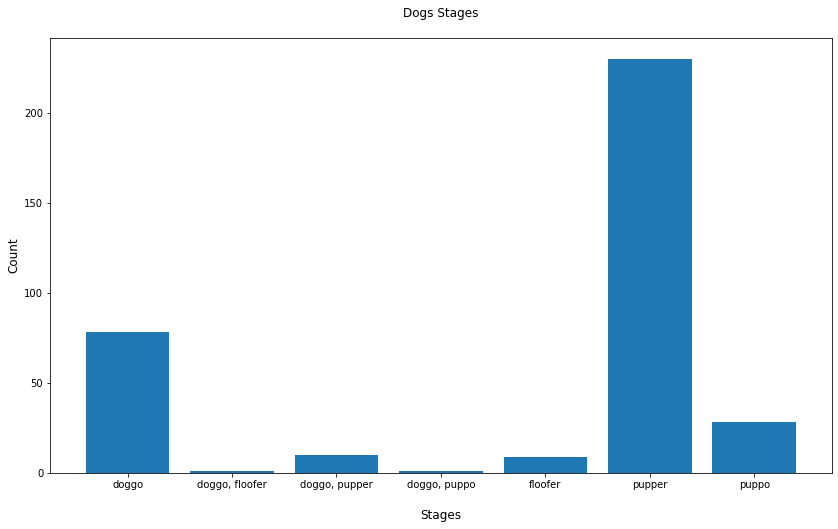

In [1079]:
# visualisation of the total count 
plt.subplots(figsize = (14, 8));
plt.bar([1, 2, 3, 4, 5, 6, 7], stage_groups, tick_label = stage_values);
plt.title('Dogs Stages\n');
plt.xlabel('\nStages', size='large');
plt.ylabel('Count', size='large');
plt.savefig('stages_count.png');

In [1080]:
stage_groups_fav = df_master.groupby(['stage'])['favorite_count'].sum()
stage_groups_fav.sort_values(ascending=False)

stage
pupper            1504194
doggo             1277463
puppo              497319
doggo, pupper      110429
floofer             99580
doggo, puppo        47844
doggo, floofer      17169
Name: favorite_count, dtype: int64

In [1081]:
stage_groups_ret = df_master.groupby(['stage'])['retweet_count'].sum()
stage_groups_ret.sort_values(ascending=False)

stage
pupper            658144
doggo             616316
puppo             178059
doggo, pupper      53813
floofer            37403
doggo, puppo       19196
doggo, floofer      3433
Name: retweet_count, dtype: int64

Obviously, the number of stages represented is disproportional. Thus, we can see that puppers have the most number of favorite counts and retweet counts. However, the second greatest number is 'doggo' stage, while the number of doggo records is less than the number of puppo records (230 vs 78). 

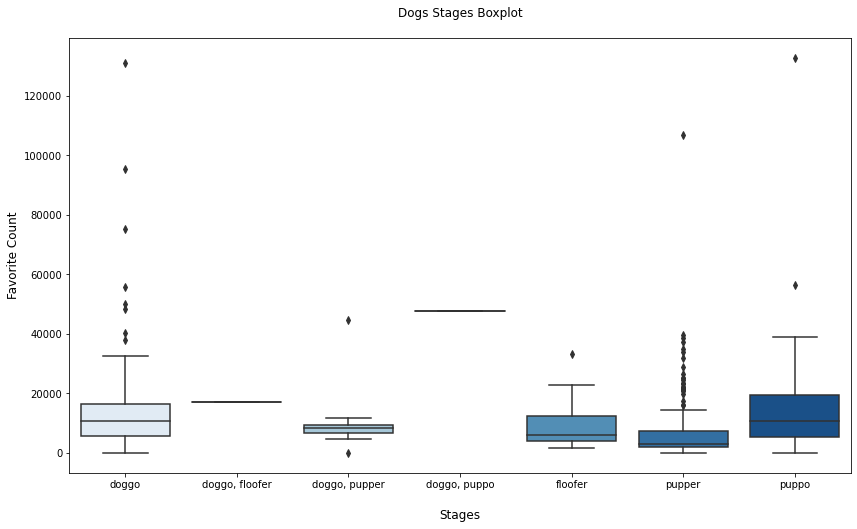

In [1082]:
# plotting dog's stage vs favorite count 
plt.figure(figsize=(14, 8));
sns.boxplot(y=df_master["favorite_count"], x=df_master["stage"], palette="Blues", order=stage_values);
plt.title('Dogs Stages Boxplot\n');
plt.xlabel('\nStages', size='large');
plt.ylabel('Favorite Count', size='large');
plt.savefig('stages_boxplot.png');
plt.show();

The order was arranged following the graph above to compare. Though puppper stage has the most total count, favorite count's median is rather low with a relatively small IQR. At the same time, some puppers have a few outliers with one of them being the thirst highest among all tweets.
We can disregard 'mixed' plots with more than one stage, since it might mean more than one dog was tweeted. 
Doggo stage has one of the highest means and some exceptional outliers with favorite count over 40.000.

In [1083]:
# having a look at the doggos with > 40000 favorite likes
df_master.query('stage == "doggo" & favorite_count > 40000')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,breed,prediction,retweet_count,favorite_count
222,846514051647705089,2017-03-28 00:07:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Barney. He's an elder doggo. Hitches a...,https://twitter.com/dog_rates/status/846514051...,13,10,Barney,doggo,https://pbs.twimg.com/media/C79sB4xXwAEvwKY.jpg,2.0,golden_retriever,0.650003,13076,48410
358,826848821049180160,2017-02-01 17:44:55+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cupid. He was found in the trash. Now ...,https://twitter.com/dog_rates/status/826848821...,13,10,Cupid,doggo,https://pbs.twimg.com/media/C3mOnZ_XUAAjr2V.jpg,4.0,great_pyrenees,0.858764,11878,40325
418,819006400881917954,2017-01-11 02:21:57+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sunny. She was also a very good First ...,https://twitter.com/dog_rates/status/819006400...,14,10,Sunny,doggo,NaN,NaN,NaN,NaN,21794,49960
419,819004803107983360,2017-01-11 02:15:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1.0,standard_poodle,0.351308,42228,95450
588,795464331001561088,2016-11-07 03:14:10+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Elder doggo does a splash. Both 13/10 incredib...,https://twitter.com/dog_rates/status/795464331...,13,10,None,doggo,https://pbs.twimg.com/ext_tw_video_thumb/79546...,1.0,golden_retriever,0.193082,27728,55683
980,744234799360020481,2016-06-18 18:26:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,None,doggo,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1.0,labrador_retriever,0.825333,79515,131075
1016,739238157791694849,2016-06-04 23:31:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,https://twitter.com/dog_rates/status/739238157...,13,10,None,doggo,https://pbs.twimg.com/ext_tw_video_thumb/73923...,1.0,eskimo_dog,0.503372,52360,75163


### Analysis 2: Top rated records

#### Favorite count

In [1084]:
top3_fav = df_master.nlargest(3, "favorite_count", keep="first")
top3_fav

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,breed,prediction,retweet_count,favorite_count
384,822872901745569793,2017-01-21 18:26:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,10,None,puppo,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1.0,lakeland_terrier,0.196015,48265,132810
980,744234799360020481,2016-06-18 18:26:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,None,doggo,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1.0,labrador_retriever,0.825333,79515,131075
61,879415818425184262,2017-06-26 19:07:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,https://twitter.com/dog_rates/status/879415818...,13,10,Duddles,NaN,https://pbs.twimg.com/ext_tw_video_thumb/87941...,1.0,english_springer,0.383404,45849,107956


Top 3 most favorite records are:
- 1) Puppo with no name, 13/10 rating, 132810 favorite counts.
- 2) Doggo with no name, 13/10 rating, 131075 favorite counts.
- 3) Duddles, 13/10 rating, 107956 favorite counts.

In [1085]:
def find_and_plot_image(tweets, figname):
    top_tweet = tweets.iloc[0]
    top_url = top_tweet.jpg_url
    if (top_url is np.nan):
        print("No image record found")
    else:
        print(top_url)
        resp = rq.get(top_url)
        img = Image.open(BytesIO(resp.content))
        txt = top_tweet.text
        breed = top_tweet.breed
        breed = breed.replace('_', ' ').upper()
        prediction = "{:.2f}".format(top_tweet.prediction)
        plt.figure(figsize=(12, 8));
        plt.axis('off');
        plt.title(top_tweet.text + "\n" + breed + " with " + prediction + " confidence");
        plt.imshow(img);
        plt.savefig(figname);
        plt.show();

https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg


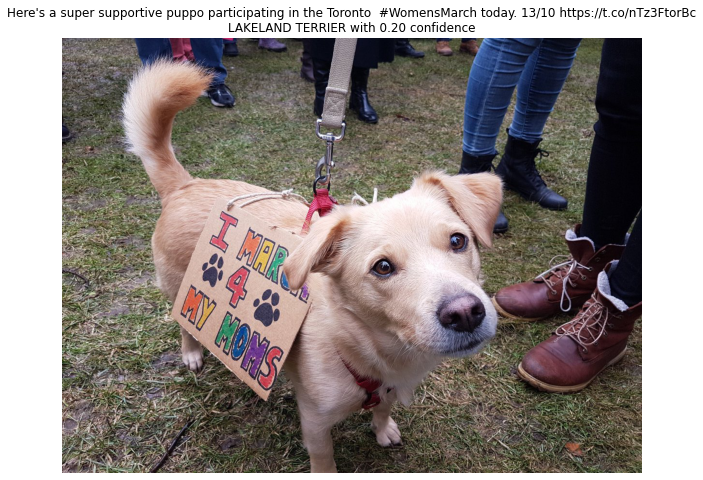

In [1086]:
find_and_plot_image(top3_fav, "top_fav_pic.png")

#### Retweet count

In [1087]:
top3_ret = df_master.nlargest(3, "retweet_count", keep="first")
top3_ret

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,breed,prediction,retweet_count,favorite_count
980,744234799360020481,2016-06-18 18:26:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,None,doggo,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1.0,labrador_retriever,0.825333,79515,131075
242,842892208864923648,2017-03-18 00:15:37+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,NaN,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1.0,chihuahua,0.505370,56625,0
502,807106840509214720,2016-12-09 06:17:20+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,NaN,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1.0,chihuahua,0.505370,56625,107015


https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg


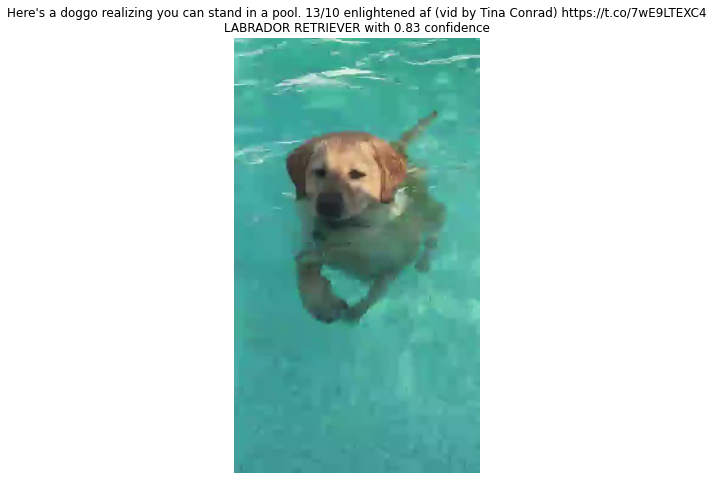

In [1088]:
find_and_plot_image(top3_ret, "top_retweet_pic.png")

How about the tweets with the least number of favorite and retweet count?

In [1089]:
bottom3_fav = df_master.nsmallest(3, "favorite_count", keep="first")
bottom3_fav

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,breed,prediction,retweet_count,favorite_count
30,886054160059072513,2017-07-15 02:45:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,https://twitter.com/dog_rates/status/886053434...,12,10,None,NaN,NaN,NaN,NaN,NaN,108,0
34,885311592912609280,2017-07-13 01:35:06+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,NaN,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1.0,labrador_retriever,0.908703,19297,0
63,879130579576475649,2017-06-26 00:13:58+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,NaN,NaN,NaN,NaN,NaN,7181,0


In [1090]:
find_and_plot_image(bottom3_fav, "bottom_fav_pic.png")

No image record found


https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg


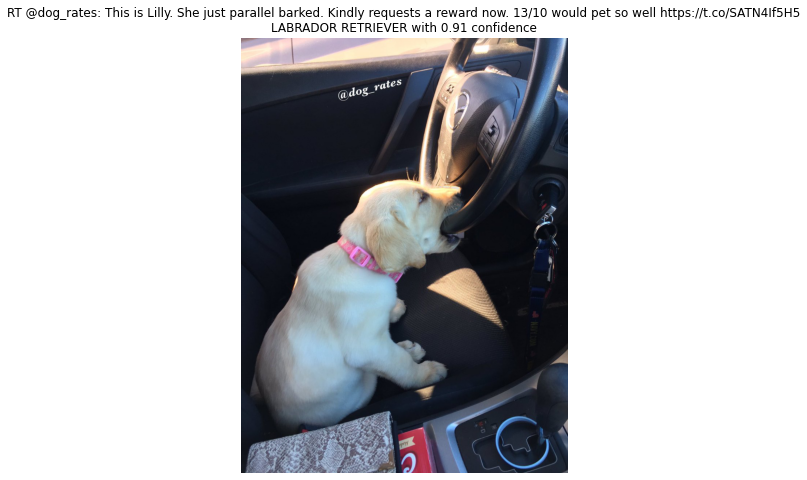

In [1091]:
# trying to display the second record
find_and_plot_image(bottom3_fav[1:], "bottom_fav_pic.png")

It does not feel right... This puppy looks super cute to have 0 favorite likes. However, we do not know how exactly favorite count was collected and if it was a part of a competition. If we look at other metrics of this tweet, we can see that it has 13/10 rating just like the top 3 tweets. It also has 19297 retweets, so this puppy had a minute of a well deserved fame.

### Analysis 3: What was the trend over time?

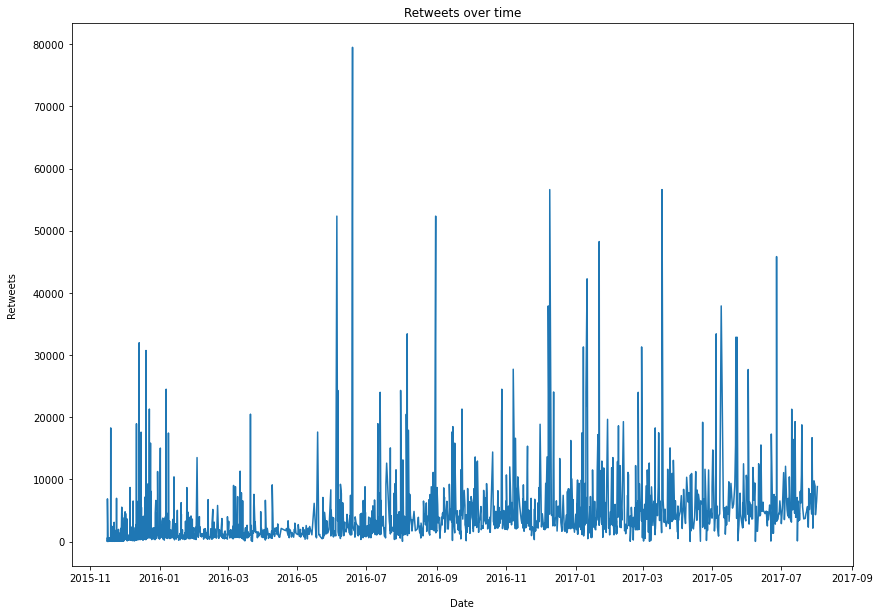

In [1092]:
# plotting a chart 
plt.figure(figsize=(14,10));
plt.plot(df_master["timestamp"], df_master["retweet_count"]);  

plt.xlabel("\nDate");
plt.ylabel("Retweets\n");
plt.title("Retweets over time");
plt.savefig("retweets.png");

plt.show();

Looks like there were sudden spikes from time to time. We need to use monthly metric.

In [1093]:
monthly_tweets = df_master.groupby(pd.Grouper(key="timestamp", freq="1M"))["retweet_count"].sum().reset_index()

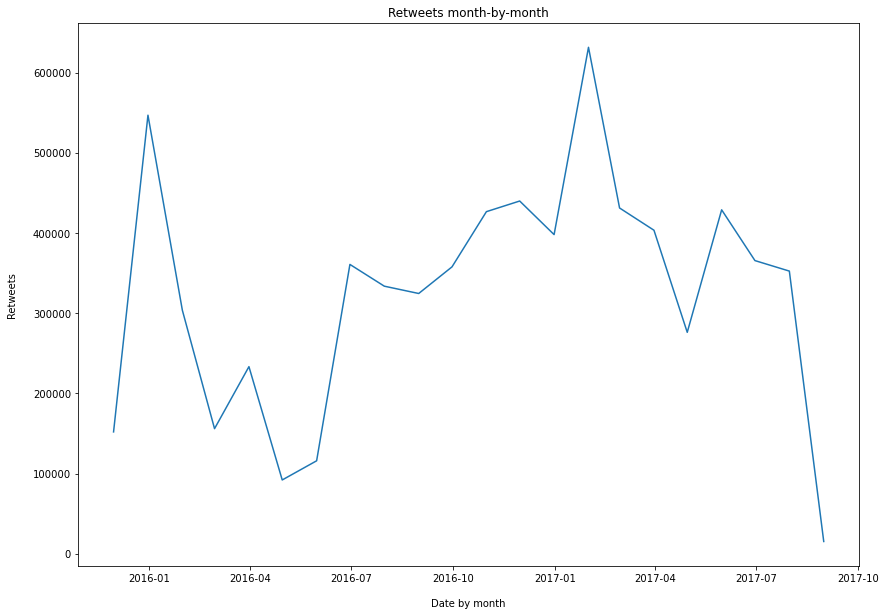

In [1094]:
plt.figure(figsize=(14,10));
plt.plot(monthly_tweets.timestamp, monthly_tweets.retweet_count);

plt.xlabel("\nDate by month");
plt.ylabel("Retweets\n");
plt.title("Retweets month-by-month");
plt.savefig("retweets_month.png");

plt.show();

There are 2 spikes in active retweets in January 2016 and March 2017, and drops in May 2016. It also indictes the tweets stopped around August 2017 (0 retweets). The top months recorded over 550.000 retweets! WeRateDogs had a lot of fans. 

## Conclusion
<a id='conclusion'></a>

This project demonstrates how cleaning quality and tidiness issues help to find insights. Not all issues were cleaned, since working them out is a long and tedious process. Only the most important and crusial issues were eliminated. For example, 'text' field could be checked for missing data such as name, numerator, denominator, expanded url. 
The analysis section showed that WeRateDogs had many fans that instantly upvoted tweets with cute dogs. Most of the time, the tweet account has received at least 100.000 retweets every month. The pictures of dogs were also loaded via requests library to demonstrate the cuteness of the dogs.